In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMRegressor
import optuna

from twws.select_variables import Selector, get_units_only
from twws.variables_list import category_columns, non_object_columns

pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('../data/data.csv')

/Users/piotr.gabrys/.local/share/virtualenvs/tww_stats-PBBeHRjs/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (617) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = get_units_only(df)

In [4]:
df.shape

(556, 620)

In [5]:
df.missile_primary__ignition_amount = df.missile_primary__ignition_amount.map({'True': 1, '0': 0, '25': 25})

In [6]:
for col in non_object_columns:
    df[col] = df[col] * 1
    df[col] = df[col].fillna(-1)

In [7]:
for col in category_columns:
    df[col] = df[col].fillna('missing')

In [8]:
df = df.loc[:, non_object_columns + category_columns + ['name']]

In [9]:
df = df.sample(frac=1)

In [10]:
df.shape

(556, 466)

In [67]:
y = df.multiplayer_cost.apply(np.log)
x = df.drop('multiplayer_cost', axis=1)

In [12]:
columns_to_remove = ['multiplayer_cost',                       
                     'speed',
                     'charge_speed', 
                     'missile_primary__total_accuracy',
                     'knock_interrupts_ignore_chance',
                     'missile_primary__reload_time',
                     'missile_primary__ammo',
                     'deceleration',
                     'unit_size',
                     'melee__ap_damage']

In [13]:
for col in columns_to_remove:
    non_object_columns.remove(col)

In [14]:
model = make_pipeline(
    make_union(
        Selector(non_object_columns), 
        make_pipeline(
            Selector(category_columns), 
            OneHotEncoder(handle_unknown='ignore')
        )
    ),
    LGBMRegressor(objective='mae')
)

In [15]:
def objective(trial):    
        
    lgbmregressor__num_leaves = trial.suggest_int('lgbmregressor__num_leaves', 2, 500) 
    lgbmregressor__max_depth = trial.suggest_int('lgbmregressor__max_depth', 2, 150) 
    lgbmregressor__n_estimators = trial.suggest_int('lgbmregressor__n_estimators', 10, 500) 
    lgbmregressor__subsample_for_bin = trial.suggest_int('lgbmregressor__subsample_for_bin', 2000, 500_000) 
    lgbmregressor__min_child_samples = trial.suggest_int('lgbmregressor__min_child_samples', 4, 500) 
    lgbmregressor__reg_alpha = trial.suggest_uniform('lgbmregressor__reg_alpha', 0.0, 1.0) 
    lgbmregressor__colsample_bytree = trial.suggest_uniform('lgbmregressor__colsample_bytree', 0.6, 1.0) 
    lgbmregressor__learning_rate = trial.suggest_loguniform('lgbmregressor__learning_rate', 1e-5, 1e-0)   
    

    params = {
        'lgbmregressor__num_leaves': lgbmregressor__num_leaves,
        'lgbmregressor__max_depth': lgbmregressor__max_depth,
        'lgbmregressor__n_estimators': lgbmregressor__n_estimators,
        'lgbmregressor__subsample_for_bin': lgbmregressor__subsample_for_bin,
        'lgbmregressor__min_child_samples': lgbmregressor__min_child_samples,
        'lgbmregressor__reg_alpha': lgbmregressor__reg_alpha,
        'lgbmregressor__colsample_bytree': lgbmregressor__colsample_bytree,
        'lgbmregressor__learning_rate': lgbmregressor__learning_rate
    }
    
    model.set_params(**params)
    
    cv = KFold(n_splits=8)

    return - np.mean(cross_val_score(model, x, y, cv=8, scoring='neg_median_absolute_error'))

In [66]:
study = optuna.create_study()
# study.optimize(objective, n_trials=100)

In [17]:
model.set_params(**study.best_params)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('selector',
                                                 <twws.select_variables.Selector object at 0x1376997c0>),
                                                ('pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  <twws.select_variables.Selector object at 0x137699880>),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.913054828956877,
                               learning_rate=0.10252419123041778, max_depth=82,
                               min_child_samples=4, n_estimators=372,
                               num_leaves=298, objective='mae',
                           

In [18]:
model.fit(x, y)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('selector',
                                                 <twws.select_variables.Selector object at 0x1376997c0>),
                                                ('pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  <twws.select_variables.Selector object at 0x137699880>),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.913054828956877,
                               learning_rate=0.10252419123041778, max_depth=82,
                               min_child_samples=4, n_estimators=372,
                               num_leaves=298, objective='mae',
                           

In [19]:
est = model.named_steps['lgbmregressor']

In [20]:
len(est.feature_importances_)

493

In [21]:
len(category_columns + non_object_columns)

455

In [22]:
ohe = model.named_steps['featureunion'].transformer_list[1][1].named_steps['onehotencoder']

In [23]:
features = non_object_columns + list(ohe.get_feature_names())

In [24]:
feature_importances = pd.DataFrame(features, columns=['features'])

In [25]:
feature_importances['importance'] = est.feature_importances_

In [26]:
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [27]:
feature_importances = feature_importances.loc[feature_importances.importance > 100, :]

In [28]:
feature_importances.shape

(28, 2)

In [29]:
feature_importances.reset_index(drop=True, inplace=True)

In [30]:
feature_importances

,features,importance
0,melee_defence,2986
1,health,2887
2,melee_attack,2683
3,leadership,2540
4,armour,1698
5,health_per_entity,1694
6,run_speed,1562
7,missile_primary__damage,1560
8,charge_bonus,1552
9,melee__ap_ratio,1330


In [38]:
corrs = df.loc[:, feature_importances.features].corr(method='spearman')

In [39]:
corrs.shape

(28, 28)

In [40]:
corrs = corrs - np.eye(corrs.shape[0])

In [41]:
corrs = np.abs(corrs)

In [42]:
corrs.max().max()

0.9060622479580703

In [43]:
corrs.max().sort_values()

damage_mod_physical                      0.192012
parry_chance                             0.316171
melee__bonus_v_large                     0.340012
melee__splash_attack_power_multiplier    0.344156
melee__bonus_v_infantry                  0.348457
fly_speed                                0.389313
health                                   0.435953
accuracy                                 0.450800
armour                                   0.484898
melee__melee_attack_interval             0.569929
melee__splash_attack_max_attacks         0.574834
leadership                               0.593331
melee_defence                            0.621804
melee__base_damage                       0.625686
melee__ap_ratio                          0.688265
charge_bonus                             0.697474
melee_attack                             0.715890
melee__damage                            0.715890
melee__weapon_length                     0.717220
height                                   0.742009


In [68]:
features = list(feature_importances.features.values)

NameError: name 'feature_importances' is not defined

In [69]:
model = make_pipeline(
    Selector(features),
    LGBMRegressor(objective='mae')
)

In [48]:
def objective(trial):    
        
    lgbmregressor__num_leaves = trial.suggest_int('lgbmregressor__num_leaves', 2, 500) 
    lgbmregressor__max_depth = trial.suggest_int('lgbmregressor__max_depth', 2, 150) 
    lgbmregressor__n_estimators = trial.suggest_int('lgbmregressor__n_estimators', 10, 500) 
    lgbmregressor__subsample_for_bin = trial.suggest_int('lgbmregressor__subsample_for_bin', 2000, 500_000) 
    lgbmregressor__min_child_samples = trial.suggest_int('lgbmregressor__min_child_samples', 4, 500) 
    lgbmregressor__reg_alpha = trial.suggest_uniform('lgbmregressor__reg_alpha', 0.0, 1.0) 
    lgbmregressor__colsample_bytree = trial.suggest_uniform('lgbmregressor__colsample_bytree', 0.6, 1.0) 
    lgbmregressor__learning_rate = trial.suggest_loguniform('lgbmregressor__learning_rate', 1e-5, 1e-0)   
    

    params = {
        'lgbmregressor__num_leaves': lgbmregressor__num_leaves,
        'lgbmregressor__max_depth': lgbmregressor__max_depth,
        'lgbmregressor__n_estimators': lgbmregressor__n_estimators,
        'lgbmregressor__subsample_for_bin': lgbmregressor__subsample_for_bin,
        'lgbmregressor__min_child_samples': lgbmregressor__min_child_samples,
        'lgbmregressor__reg_alpha': lgbmregressor__reg_alpha,
        'lgbmregressor__colsample_bytree': lgbmregressor__colsample_bytree,
        'lgbmregressor__learning_rate': lgbmregressor__learning_rate
    }
    
    model.set_params(**params)
    
    cv = KFold(n_splits=8)

    return - np.mean(cross_val_score(model, x, y, cv=8, scoring='neg_median_absolute_error'))

In [65]:
study = optuna.create_study()
# study.optimize(objective, n_trials=500)

In [70]:
features = ["melee_defence",
"health",
"melee_attack",
"leadership",
"armour",
"health_per_entity",
"run_speed",
"missile_primary__damage",
"charge_bonus",
"melee__ap_ratio",
"melee__base_damage",
"mass",
"melee__damage",
"height",
"melee__melee_attack_interval",
"acceleration",
"melee__bonus_v_large",
"melee__bonus_v_infantry",
"melee__splash_attack_max_attacks",
"parry_chance",
"reload",
"hit_reactions_ignore_chance",
"melee__weapon_length",
"damage_mod_physical",
"accuracy",
"combat_reaction_radius",
"fly_speed",
"melee__splash_attack_power_multiplier"]

In [71]:
model = make_pipeline(
    Selector(features),
    LGBMRegressor(objective='mae')
)

In [72]:
best_params = {'lgbmregressor__num_leaves': 434,
 'lgbmregressor__max_depth': 110,
 'lgbmregressor__n_estimators': 256,
 'lgbmregressor__subsample_for_bin': 82449,
 'lgbmregressor__min_child_samples': 4,
 'lgbmregressor__reg_alpha': 0.14126751650012037,
 'lgbmregressor__colsample_bytree': 0.7745213812855362,
 'lgbmregressor__learning_rate': 0.04242070860113767}

In [73]:
model.set_params(**best_params)

Pipeline(steps=[('selector',
                 <twws.select_variables.Selector object at 0x1354e4cd0>),
                ('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.7745213812855362,
                               learning_rate=0.04242070860113767, max_depth=110,
                               min_child_samples=4, n_estimators=256,
                               num_leaves=434, objective='mae',
                               reg_alpha=0.14126751650012037,
                               subsample_for_bin=82449))])

In [74]:
model.fit(x, y)

Pipeline(steps=[('selector',
                 <twws.select_variables.Selector object at 0x1354e4cd0>),
                ('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.7745213812855362,
                               learning_rate=0.04242070860113767, max_depth=110,
                               min_child_samples=4, n_estimators=256,
                               num_leaves=434, objective='mae',
                               reg_alpha=0.14126751650012037,
                               subsample_for_bin=82449))])

In [75]:
yhat = model.predict(x)

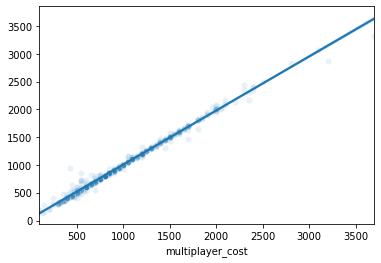

In [76]:
sns.regplot(y.apply(np.exp), np.exp(yhat), scatter=False)
sns.scatterplot(y.apply(np.exp), np.exp(yhat), alpha=0.1);

In [96]:
y = df.multiplayer_cost.apply(np.log)
x = df.drop('multiplayer_cost', axis=1)

x['yhat'] = np.exp(yhat)
x['y'] = y.apply(np.exp)
x['res'] =  x.yhat - x.y
x['res_perc'] = x.yhat / x.y

x.sort_values(by='res_perc', ascending=False, inplace=True)

In [98]:
x.iloc[:20, -5:]

,name,res,yhat,y,res_perc
59,Bloated Corpse,514.370168,939.370168,425.0,2.210283
266,Zombies,89.498844,189.498844,100.0,1.894988
1210,Spider Hatchlings,131.129941,281.129941,150.0,1.874200
342,Peasant Mob,64.551674,164.551674,100.0,1.645517
276,Corpse Cart,158.240059,408.240059,250.0,1.632960
1029,Aspiring Champions,313.416831,863.416831,550.0,1.569849
896,Feral Cold Ones,197.277066,647.277066,450.0,1.438393
1139,Archers,124.976498,474.976498,350.0,1.357076
812,Poisoned Wind Globadiers,186.622199,736.622199,550.0,1.339313
1140,Deathjacks (Archers),181.987086,731.987086,550.0,1.330886
